In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

DATA_DIR = Path.cwd() / 'data'
OUTPUT_DIR = Path.cwd() / 'output'

def printUnique(df, col=None):
    if col is None:
        print(f"total index: {df.index.size}")
        print(f"unique index: {df.index.unique().size}")
    else:
        print(f"total {col}: {df[col].size}")
        print(f"unique {col}: {df[col].unique().size}")

In [2]:
"""
UKBB Survival Data
"""
# G30 (alzheimer's disease)
# G31 (other degenerative diseases of nervous system not elsewhere classified)
# G32 (other degenerative disorders of nervous system in diseases classified elsewhere)
df_surv = pd.read_csv(DATA_DIR / 'Participant_table.csv')
df_surv = df_surv.dropna(how='all', subset=df_surv.columns.drop('Participant ID'))

# Convert date datatypes
df_surv['Date G30'] = pd.to_datetime(df_surv['Date G30'])
df_surv['Date G31'] = pd.to_datetime(df_surv['Date G31'])
df_surv['Date G32'] = pd.to_datetime(df_surv['Date G32'])

print(df_surv.dtypes)
df_surv

Participant ID             int64
Date G31          datetime64[ns]
Date G32          datetime64[ns]
Date G30          datetime64[ns]
dtype: object


,Participant ID,Date G31,Date G32,Date G30
0,1001678,1998-08-21,NaT,NaT
1,1002597,2018-12-05,NaT,NaT
2,1002614,2022-03-01,NaT,NaT
3,1002673,2020-11-09,NaT,NaT
4,1003571,2022-01-02,NaT,NaT
...,...,...,...,...
3723,6013574,1991-07-01,NaT,NaT
3724,6017814,2018-10-01,NaT,2016-03-26
3725,6017926,1999-09-13,NaT,NaT
3726,6019124,2017-05-13,NaT,NaT


In [3]:
# Calculate # of days between exam dates
df_surv['Days1'] = df_surv[~df_surv['Date G30'].isnull()]['Date G30'] - df_surv[~df_surv['Date G31'].isnull()]['Date G31']
df_surv['Days1'] = pd.to_numeric(df_surv['Days1'].dt.days, downcast='integer')
df_surv.loc[df_surv['Days1'].isnull(), 'Days1'] = 0

df_surv['Days2'] = df_surv[~df_surv['Date G30'].isnull()]['Date G30'] - df_surv[~df_surv['Date G32'].isnull()]['Date G32']
df_surv['Days2'] = pd.to_numeric(df_surv['Days2'].dt.days, downcast='integer')
df_surv.loc[df_surv['Days2'].isnull(), 'Days2'] = 0

df_surv['Days'] = df_surv[['Days1', 'Days2']].max(axis=1)
df_surv = df_surv.drop(['Days1', 'Days2'], axis=1)

# Only take events with NON-ZERO duration
df_surv = df_surv[df_surv['Days'] > 0]

# Set events
# 0 = no progression
# 1 = yes progression
df_surv['Event'] = 0
df_surv.loc[~df_surv['Date G30'].isnull(), 'Event'] = 1

printUnique(df_surv, 'Participant ID')
df_surv

total Participant ID: 198
unique Participant ID: 198


,Participant ID,Date G31,Date G32,Date G30,Days,Event
16,1019725,2012-04-09,NaT,2019-05-28,2605.0,1
23,1030670,2017-05-11,NaT,2018-12-24,592.0,1
27,1041881,2021-03-26,NaT,2022-01-10,290.0,1
57,1079534,2002-06-14,NaT,2019-07-22,6247.0,1
73,1104453,2021-07-05,NaT,2021-12-29,177.0,1
...,...,...,...,...,...,...
3681,5955024,2019-11-29,NaT,2020-08-06,251.0,1
3691,5967446,2013-06-26,NaT,2014-07-08,377.0,1
3692,5967820,2020-12-18,NaT,2020-12-22,4.0,1
3700,5980368,2010-12-13,NaT,2011-07-19,218.0,1


In [4]:
"""
UKBB Proteomics Data
"""
# Load data in chunks
df1 = pd.read_csv(DATA_DIR / 'proteomics-full-20.csv')
df2 = pd.read_csv(DATA_DIR / 'proteomics-full-40.csv')
df3 = pd.read_csv(DATA_DIR / 'proteomics-full-60.csv')
df4 = pd.read_csv(DATA_DIR / 'proteomics-full-80.csv')
df5 = pd.read_csv(DATA_DIR / 'proteomics-full-89.csv')

# Merge chunks of data
df_proteomics = df1.merge(df2, on='Participant ID', how='inner')
df_proteomics = df_proteomics.merge(df3, on='Participant ID', how='inner')
df_proteomics = df_proteomics.merge(df4, on='Participant ID', how='inner')
df_proteomics = df_proteomics.merge(df5, on='Participant ID', how='inner')

df_proteomics.columns = [col.split(';')[0] for col in df_proteomics.columns]

# Impute missing protein expression values
# KNN Imputation; 2 neighbors; uniform weights
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2, weights="uniform")
df_proteomics = pd.DataFrame(imputer.fit_transform(df_proteomics), columns=df_proteomics.columns)

printUnique(df_proteomics, 'Participant ID')
df_proteomics

total Participant ID: 589
unique Participant ID: 589


,Participant ID,ACADM,ACTA2,ACTN4,AHCY,ANXA1,ANXA11,ANXA2,ANXA3,ANXA4,...,STX8,TALDO1,TNC,TNFRSF1A,TOMM20,TOP1,TUBB3,VIM,VTI1A,YWHAQ
0,1003571.0,-0.00190,1.7631,0.47280,0.3953,0.0843,0.4422,0.25980,0.42190,0.2483,...,0.19580,0.00190,0.75270,0.9529,0.6189,-0.283425,0.096875,-0.71185,0.354000,0.69420
1,1021489.0,0.51820,0.6907,0.38620,-0.0228,-0.0216,0.0741,0.13420,0.13490,0.1259,...,-0.41010,-0.02180,-0.18550,0.3440,0.0949,-0.840700,0.003900,-0.27590,-0.257800,0.30050
2,1027548.0,-0.39910,0.3644,-0.05075,-0.0028,0.0404,-0.2528,-0.16685,-0.82975,-0.9098,...,-0.29525,-0.26870,-0.16325,0.5351,-0.2183,0.273850,0.189850,-0.51860,-0.386550,-0.84400
3,1041881.0,0.80380,0.0533,0.34995,0.9770,0.4955,0.6080,1.60015,0.36675,0.8856,...,0.47545,0.27970,-0.71205,0.0426,1.0723,0.338750,0.341150,0.65330,0.501950,0.63440
4,1047211.0,-0.19190,-0.0048,0.05595,0.0283,-0.1703,-0.3400,-0.23945,-0.52935,-0.1450,...,-0.24125,-0.38330,0.54185,0.6304,-0.1956,-1.564150,-0.115850,0.13930,-0.320150,-0.22060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584,5962571.0,-0.21440,0.4031,-0.09125,0.3025,0.3160,-0.6663,0.21255,-0.61125,-0.1630,...,-0.36740,0.45795,1.36315,-0.5552,-0.1186,-1.373950,0.062900,0.60575,0.013575,0.53260
585,5967820.0,-0.25920,0.0689,0.12230,0.6840,0.5290,0.7074,-0.51180,1.41430,1.7694,...,0.01025,0.76640,-0.28125,0.3131,-0.3225,-1.770750,0.082150,0.58890,0.417150,0.83270
586,5975554.0,-0.21960,-0.4560,-0.26900,0.2432,-0.4204,0.5126,0.43350,0.78850,0.5415,...,0.40425,0.28630,-0.14955,0.0470,0.7652,1.179750,-0.081250,-0.29730,0.090350,0.62390
587,6011546.0,-0.05810,0.0037,-0.01360,-1.5333,0.0694,-1.8602,-0.38420,-1.91540,-1.6397,...,-0.73605,-0.92780,-1.31045,-0.2302,-0.0140,-0.354050,0.123250,-0.67720,-0.447450,-1.26720


In [5]:
"""
UKBB Demographic Data
"""
# Male = 0
# Female = 1
df = pd.read_csv(DATA_DIR / 'Demographics.csv')
df_demo = df.drop('Year of birth', axis=1)
df_demo['Sex'] = df_demo['Sex'].map({'Male': 0, 'Female': 1})
df_demo

,Participant ID,Sex,Age at recruitment
0,1001678,0,50
1,1002597,1,60
2,1002614,0,51
3,1002673,0,54
4,1003571,1,59
...,...,...,...
3723,6013574,1,59
3724,6017814,0,65
3725,6017926,0,56
3726,6019124,0,68


In [6]:
# Merge survival + proteomics data
df_surv_prot = df_surv[['Participant ID', 'Days', 'Event']].merge(df_proteomics, on='Participant ID', how='inner')

df_surv_prot.head()

,Participant ID,Days,Event,ACADM,ACTA2,ACTN4,AHCY,ANXA1,ANXA11,ANXA2,...,STX8,TALDO1,TNC,TNFRSF1A,TOMM20,TOP1,TUBB3,VIM,VTI1A,YWHAQ
0,1041881,290.0,1,0.8038,0.05330,0.34995,0.9770,0.4955,0.6080,1.600150,...,0.47545,0.27970,-0.71205,0.0426,1.0723,0.33875,0.34115,0.65330,0.50195,0.63440
1,1592016,42.0,1,-0.2785,-0.22445,0.06355,0.2644,-0.3414,0.2946,-1.133900,...,-0.28335,0.00520,0.11045,-0.2493,-0.0722,0.36465,-0.73965,-1.83070,0.22190,0.01490
2,1791679,3389.0,1,-0.5394,0.31620,0.09990,-1.2737,-0.2955,-1.6681,-1.259600,...,0.78615,-1.23960,0.00915,-0.1450,-0.5045,-0.27265,-0.28425,0.78750,-0.52745,-1.66640
3,1792719,199.0,1,-0.1505,0.48590,-0.09380,-0.4410,0.3874,-0.3074,-0.299800,...,-0.27840,0.01110,-0.57280,0.0606,-0.4869,0.62635,0.13525,-1.49285,-0.33130,-0.31920
4,1897904,46.0,1,0.2061,0.16520,-0.08415,-0.7417,-0.1128,0.0204,-0.023125,...,-0.35080,0.36315,1.03025,-0.0001,0.9661,-1.44105,-0.00715,-1.08425,0.38155,0.79315


In [7]:
# Merge all data to create the final dataset used in TTE analysis
df_surv_prot_demo = df_surv_prot.merge(df_demo, on='Participant ID', how='inner')

df_surv_prot_demo = df_surv_prot_demo.astype({'Sex': 'category'})
df_surv_prot_demo = df_surv_prot_demo.rename(columns={'Age at recruitment': 'Age'})

#printUnique(df_surv_prot_demo, 'Participant ID')
#print(df_surv_prot_demo[df_surv_prot_demo['Event'] == 0].shape[0])
#print(df_surv_prot_demo[df_surv_prot_demo['Event'] == 1].shape[0])
df_surv_prot_demo.head()

,Participant ID,Days,Event,ACADM,ACTA2,ACTN4,AHCY,ANXA1,ANXA11,ANXA2,...,TNC,TNFRSF1A,TOMM20,TOP1,TUBB3,VIM,VTI1A,YWHAQ,Sex,Age
0,1041881,290.0,1,0.8038,0.05330,0.34995,0.9770,0.4955,0.6080,1.600150,...,-0.71205,0.0426,1.0723,0.33875,0.34115,0.65330,0.50195,0.63440,0,63
1,1592016,42.0,1,-0.2785,-0.22445,0.06355,0.2644,-0.3414,0.2946,-1.133900,...,0.11045,-0.2493,-0.0722,0.36465,-0.73965,-1.83070,0.22190,0.01490,0,67
2,1791679,3389.0,1,-0.5394,0.31620,0.09990,-1.2737,-0.2955,-1.6681,-1.259600,...,0.00915,-0.1450,-0.5045,-0.27265,-0.28425,0.78750,-0.52745,-1.66640,1,65
3,1792719,199.0,1,-0.1505,0.48590,-0.09380,-0.4410,0.3874,-0.3074,-0.299800,...,-0.57280,0.0606,-0.4869,0.62635,0.13525,-1.49285,-0.33130,-0.31920,0,66
4,1897904,46.0,1,0.2061,0.16520,-0.08415,-0.7417,-0.1128,0.0204,-0.023125,...,1.03025,-0.0001,0.9661,-1.44105,-0.00715,-1.08425,0.38155,0.79315,1,65


In [8]:
# Import model covariates (risk factors) from transcriptomics risk model
df_ts_sig = pd.read_csv(OUTPUT_DIR / 'risk_score_transcriptomics.csv')
df_ts_sig['covariate'] = df_ts_sig['covariate'].replace({'PTGENDER': 'Sex', 'AGE': 'Age'})

missing = [x for x in df_ts_sig['covariate'] if x not in df_surv_prot_demo.columns]
features = [x for x in df_ts_sig['covariate'] if x in df_surv_prot_demo.columns]

print(f"Missing: {missing}")
print(f"Features: {features}")

df_ts_sig

Missing: ['CCT8', 'HIST1H3A', 'HIST1H4F', 'HTRA1', 'NARS', 'RAB5C', 'UBB']
Features: ['KRT14', 'KRT5', 'Sex', 'Age']


,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,CCT8,-0.201015,0.817901,1.051749,-2.262405,1.860376,0.104100,6.426153,0.0,-0.191124,0.848428,0.237135
1,HIST1H3A,3.405667,30.134394,1.202908,1.048010,5.763324,2.851971,318.404962,0.0,2.831194,0.004637,7.752452
2,HIST1H4F,0.757019,2.131911,0.933976,-1.073540,2.587578,0.341796,13.297521,0.0,0.810533,0.417634,1.259690
3,HTRA1,0.658443,1.931782,0.248066,0.172242,1.144644,1.187965,3.141324,0.0,2.654302,0.007947,6.975328
4,KRT14,-3.423981,0.032582,1.151720,-5.681311,-1.166650,0.003409,0.311408,0.0,-2.972927,0.002950,8.405194
5,KRT5,-0.988947,0.371968,0.583648,-2.132877,0.154982,0.118496,1.167637,0.0,-1.694423,0.090185,3.470971
6,NARS,-2.034084,0.130800,0.942476,-3.881302,-0.186865,0.020624,0.829556,0.0,-2.158234,0.030910,5.015801
7,RAB5C,2.093022,8.109381,0.991570,0.149580,4.036463,1.161346,56.625727,0.0,2.110815,0.034788,4.845259
8,UBB,-0.710928,0.491188,1.116439,-2.899109,1.477253,0.055072,4.380893,0.0,-0.636782,0.524267,0.931627
9,Sex,0.368858,1.446082,0.319034,-0.256437,0.994153,0.773804,2.702434,0.0,1.156172,0.247611,2.013853


In [9]:
"""
Multivariate Cox Regression
"""
from lifelines import CoxPHFitter

data_cox = df_surv_prot_demo[features + ['Event', 'Days']]

# Fit model
cph_cox = CoxPHFitter()
cph_cox.fit(data_cox, 'Days', 'Event')

<lifelines.CoxPHFitter: fitted with 39 total observations, 0 right-censored observations>

In [10]:
# Select significant covariates/risk factors (significant defined by p<0.05)
cph_cox.summary.sort_values(by='p', ascending=True)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
KRT14,1.666369,5.292912,0.775098,0.147204,3.185533,1.158591,24.180168,0.0,2.149881,0.031565,4.985548
Age,0.056551,1.058180,0.033266,-0.008650,0.121752,0.991387,1.129473,0.0,1.699939,0.089142,3.487746
KRT5,0.494819,1.640202,0.308042,-0.108933,1.098571,0.896791,2.999876,0.0,1.606335,0.108200,3.208223
Sex,-0.079174,0.923879,0.333705,-0.733223,0.574875,0.480358,1.776909,0.0,-0.237258,0.812457,0.299637


In [11]:
#from pathlib import Path
#Path("./output").mkdir(parents=True, exist_ok=True)
#cph_cox.summary.to_csv(OUTPUT_DIR / 'risk_score_proteomics.csv')

In [12]:
"""
Evaluate Model
"""
df_model = pd.read_csv(OUTPUT_DIR / 'risk_score_proteomics.csv')
df_patients = data_cox

df_model

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,#REF!
0,KRT14,1.666369,5.292912,0.775098,0.147204,3.185533,1.158591,24.180168,0,2.149881,0.031565,4.985548
1,KRT5,0.494819,1.640202,0.308042,-0.108933,1.098571,0.896791,2.999876,0,1.606335,0.108200,3.208223
2,Sex,-0.079174,0.923879,0.333705,-0.733223,0.574875,0.480358,1.776909,0,-0.237258,0.812457,0.299637
3,Age,0.056551,1.058180,0.033266,-0.008650,0.121752,0.991387,1.129473,0,1.699939,0.089142,3.487746


<Axes: xlabel='Coefficient (95% CI)'>

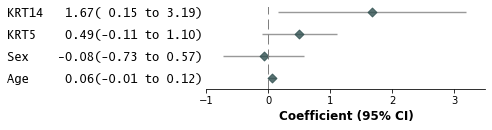

In [20]:
"""
Forest plot of risk factor coefficients
"""
import matplotlib.pyplot as plt
import forestplot as fp

fp.forestplot(
    dataframe=df_model,  # the dataframe with results data
    estimate="coef",  # col containing estimated effect size 
    ll="coef lower 95%",
    hl="coef upper 95%",
    varlabel="covariate",  # column containing variable label
    xlabel="Coefficient (95% CI)",  # x-label title
    xticks=[-1,0,1,2,3],
    **{
        'figsize': (5, 1.5),
        'xlim': (-1, 3.5),
        'marker': 'D',
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line 
        "xlinecolor": "#808080",  # gray color for x-reference line
    },
)

#plt.savefig(OUTPUT_DIR / 'forest_plot_proteomics.png', dpi=300, bbox_inches='tight')

In [14]:
"""
Risk score calculation
"""
values = df_patients.drop(['Event', 'Days'], axis=1)
coefs = df_model['coef'].to_numpy()
df_patients['pred'] = values.dot(coefs)

# Quantify risk score distribution
df_patients['pred'].describe()
#df_patients['pred']

count    39.000000
mean      3.802549
std       0.642666
min       2.467824
25%       3.325076
50%       3.766543
75%       4.312623
max       5.081286
Name: pred, dtype: float64

median:		3.766543138317
less than:	19
equal to:	1
greater than:	19


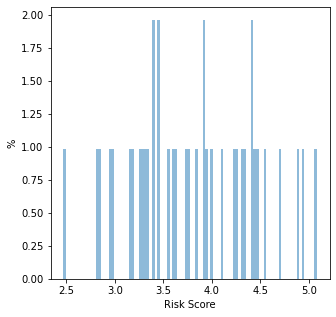

In [15]:
# Quantify risk group distribution
median = df_patients['pred'].median()
print(f"median:\t\t{median}")
print(f"less than:\t{df_patients[df_patients['pred']<median].index.size}")
print(f"equal to:\t{df_patients[df_patients['pred']==median].index.size}")
print(f"greater than:\t{df_patients[df_patients['pred']>median].index.size}")

# Visualize risk group distribution
import statsmodels.api as sm
import matplotlib.pylab as py
import matplotlib.pyplot as plt

kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)
fig = plt.figure(figsize=(5,5))
plt.hist(df_patients['pred'].astype('float'), **kwargs)

plt.gca().set(ylabel='%', xlabel='Risk Score')
#plt.savefig('gene_expr_dist.jpg', bbox_inches='tight', dpi=300)
plt.show()

In [16]:
# Set risk groups
df_patients.loc[df_patients['pred'] < median, 'risk'] = 'Low Risk'
df_patients.loc[df_patients['pred'] >= median, 'risk'] = 'High Risk'

In [17]:
# Logrank test
from lifelines.statistics import logrank_test

ix = df_patients['risk'] == 'Low Risk'
T_exp, E_exp = df_patients.loc[ix, 'Days'], df_patients.loc[ix, 'Event']
T_con, E_con = df_patients.loc[~ix, 'Days'], df_patients.loc[~ix, 'Event']

results = logrank_test(T_exp, T_con, event_observed_A=E_exp, event_observed_B=E_con)

print(results.p_value)
print(results.test_statistic)
results.print_summary()

0.005870792962691975
7.589539933382809


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.59 0.01      7.41

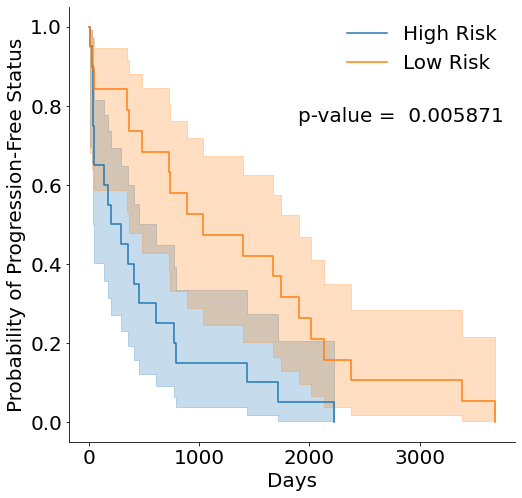

In [18]:
"""
Kaplan-Meier Plot
"""
# Kaplan-Meier time-to-event analysis
from lifelines import KaplanMeierFitter

# Plot configuration
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["font.size"] = "20"

ax = plt.subplot(111)
kmf = KaplanMeierFitter()

for name, grouped_df in df_patients.groupby('risk'):
    kmf.fit(grouped_df["Days"], grouped_df["Event"], label=name)
    kmf.plot_survival_function(ax=ax)

# Adjust plt
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.legend(frameon=False)

ax.set_xlabel("Days")
ax.set_ylabel("Probability of Progression-Free Status")

ax.text(1900, 0.75, f"p-value = {results.p_value: .6f}",
        horizontalalignment="left",
        verticalalignment="bottom")

plt.show()

# Print to PNG file
#ax.get_figure().savefig(OUTPUT_DIR / 'km_plot_proteomics.png', bbox_inches='tight', dpi=300)